In [220]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from scipy import integrate

In [263]:
# Obtiene gif de la solución
def get_animation(Q, x, U, Nt, title, titles, path):
    
    # Crea figura
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    ax1, ax2, ax3 = axs
    
    # Parámetros
    plt.xlabel(r'$x$')
    plt.ylabel(r'$Q(t, x)$')
    ax1.set_title(titles[0])
    ax2.set_title(title[1])
    
    fig.suptitle(title)
    
    ax1.set_ylim(-0.1, 0.8)
    ax2.set_ylim(-1, 60)
    ax3.set_ylim(-10, 20)
    
    ax1.set_xlabel("x")
    ax2.set_xlabel("x")
    ax3.set_ylabel("x")
    
    # Valores iniciales
    rho_0 = Q[0][0]
    y_0 = Q[0][1]
    u_0 = u(rho_0, y_0, U)
    U_eq_0 = U(rho_0)

    # Lineas iniciales
    line1, = ax1.plot(x, rho_0, '-', color='r', linewidth=2)
    line2, = ax2.plot(x, u_0, '-', color='b', linewidth=2, label=r"u")
    line3, = ax3.plot(x, U_eq_0, '-', color='g', linewidth=2)
    
    plt.legend()

    def animate(n):
        
        # Instante n
        rho = Q[n][0]
        y = Q[n][1]
        u_ = u(rho, y, U)
        U_eq = U(rho)
        
        # Actualiza gráfico
        line1.set_ydata(rho)
        line2.set_ydata(u_)
        line3.set_ydata(U_eq)

        ax1.set_title(titles[0])
        ax2.set_title(titles[1])
        ax3.set_title(titles[2])
        
        return [line1, line2, line3]

    ani = animation.FuncAnimation(fig, animate, np.arange(0, Nt, 3),
                                interval=50, blit=True)

    ani.save(path)

# Aplicación a ecuación ARZ

Se toma el modelo ARZ no homogeneo, que considera conservación de masa y del campo de velocidades shifteado. Las ecuaciones corresponden a
$$
\begin{align*}
\rho_t + (\rho u)_x &= 0\\
(u - U(\rho))_t + u(u-U(\rho))_x &= \frac{(U(\rho) - u)}{\tau}
\end{align*}
$$

donde $\rho = \rho(x, t)$ corresponde a la densidad vehicular, $u=u(x, t)$ al campo de velocidades y $U(\rho)$ velocidad de equilibrio. Consideraremos $U(\rho) = u_{\text{max}}(1-\rho^\gamma)$ con $\gamma \in (0, 1)$. En particular, se usarán $u_{\text{max}}=20$ y $\gamma=1/2$.

Definiendo $y(\rho, u)= \rho(u-U(\rho))$ y sumando ambas ecuaciones, podemos escribir el sistema en su forma conservativa:
$$
 \textbf{Q}_t + F( \textbf{Q})_x = \textbf{S}(y, \rho)
$$
donde $ \textbf{Q} = \begin{pmatrix} \rho \\ y \end{pmatrix}$, $F(\textbf{Q}) = \begin{pmatrix} \rho u\\ yu\end{pmatrix}$ y $ \textbf{S}(y, u) = \begin{pmatrix} 0 \\ -\frac{y}{\rho} \end{pmatrix}$. De esta forma se puede utilizar cualquier esquema de volúmenes finitos que se haya visto. En este caso, se usará el esquema de Godunov, que pide resolver el problema de Riemann asociado al modelo. Este se resolverá analiticamente y se programará separando en casos.

Una opción a manejar es resolver el problema de Riemann usando solvers aproximadores, pues se puede complejizar más si se resuelve el problema de Riemann no homogeneo. Se puede también resolver analíticamente pero resulta en un mayor coste computacional.

## Funciones del modelo

In [447]:
# Se pueden cambiar
u_max = 60
gamm = 1/2

# Define u en función de rho e y
def u(rho, y, U):
    output = y/rho + U(rho)
    return output

# Define y en función de rho y u
def y_u(rho, u, U):
    output = rho*(u - U(rho))
    return output

In [223]:
# Flujo del modelo
def flux(Q, U):
    
    # Rescata variables
    rho, y = Q
    
    # Obtiene u en funcion de rho e y
    u_ = u(rho, y, U)
    return np.array([rho * u_, y * u_])

In [224]:
# Flujo de Godunov de primer orden
def F(Q, N, U, l):
    
    # Guarda flujo en un arreglo
    F_ = np.zeros(Q.shape)
    
    for i in range(1, N-1):
        
        # Rescata actual y vecinos
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        
        # Problema de Riemann en cada vecino
        w_left = w(Q_left, Q_i, U)
        w_right = w(Q_i, Q_right, U)
        
        # Evalúa en el flujo del modelo
        F_[:, i] = flux(w_right, U) - flux(w_left, U)
    
    return F_

## Integral de densidad

In [456]:
def density_integral(x, dx, N_t, Q):
    integral_graph = []
    for n in range(N_t):
    
        density = Q[n, 0, :]
        integral = integrate.simpson(density, x, dx)
        integral_graph += [integral]
    
    plt.plot(integral_graph)
    plt.show()

## Resuelve el problema de Riemann

In [226]:
# Solución problema de Riemann homogeneo

# TODO: Quitar casos redundantes
# TODO: Cambiar si se quiere cambiar el h(rho) o U(rho)
# TODO: Agregar Riemann no homogeneo
def w(Q_l, Q_r, U, umax=u_max, gamma=gamm):
    
    # Rescata variables a la izquierda
    rho_l, y_l = Q_l
    
    # Rescata variables a la derecha
    rho_r, y_r = Q_r
      
    # Obtiene velocidades
    u_l = u(rho_l, y_l, U)
    u_r = u(rho_r, y_r, U)
    u_m = u_r

    # Define valor medio de rho y u
    rho_m = (rho_l**gamma + (u_l - u_r)/umax)**(1/gamma)
    
    if umax*rho_l**gamma + u_l <= u_r:
        print("No hay solución")
        print("u_r = ", u_r, "demás = ", umax*rho_l**gamma + u_l)

    # u_r y u_l cercanos
    if np.isclose(u_r, u_l):

        # Solucion en 0
        rho_0 = rho_l
        u_0 = u_l

    # u_r menor a u_l
    elif u_r < u_l:

        # Define velocidad del shock
        l_s = (rho_m * u_m - rho_l * u_l)/(rho_m - rho_l)

        # Si es positivo
        if l_s >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Si es negativo
        else:

            # Solucion en 0
            rho_0 = rho_m
            u_0 = u_m

    # Condición u_l en un intervalo en función de u_r
    elif u_r - umax*rho_l**gamma < u_l < u_r:

        # Lambdas a la izquierda y centrado con respecto al 0
        l_0_l = u_l - umax * gamma * rho_l**gamma
        l_0_m = u_r - umax*gamma*rho_l**gamma + gamma*(u_r - u_l)

        # Lambda izquierda es positivo
        if l_0_l >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Lambda derecha es negativo
        elif l_0_m <= 0:

            # Solucion en 0
            rho_0 = rho_m
            u_0 = u_m

        # A la izquierda es negativo y centrado positivo
        elif l_0_l < 0 < l_0_m:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)

            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar

    # u_l menor a u_r menos algo
    elif u_l <= u_r - umax*rho_l**gamma:

        # Lambda a la izquierda del 0
        l_0_l = u_l - umax * gamma * rho_l**gamma

        # Si es positivo
        if l_0_l >= 0:

            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l

        # Si es negativo
        else:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)

            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar

    # rho_l cero y rho_r positivo
    # TODO: Ver equivalencia a algun caso anterior
    elif np.isclose(rho_l, 0) and rho_r >0:
        rho_0 = 0
        u_0 = 0
    
    # Opuesto al anterior
    # TODO: Ver equivalencia a algun caso anterior
    elif rho_l > 0 and np.isclose(rho_r, 0):
        
        # Velocidad
        u_l = u(rho_l, y_l, U)
        
        # Obtiene lambda a la izquierda del 0
        l_0_l = u_l - umax * gamma * rho_l**gamma
        
        # Si es positivo
        if l_0_l >= 0:
            
            # Solucion en 0
            rho_0 = rho_l
            u_0 = u_l
        
        # Si es negativo
        else:
            rho_bar = ((u_l + umax*rho_l**gamma)/((gamma + 1)*umax))**(1/gamma)
            u_bar = (gamma/(gamma+1)) * (u_l + umax*rho_l**gamma)
            
            # Solucion en 0
            rho_0 = rho_bar
            u_0 = u_bar
    
    # rho_l  es cero
    # TODO: Escribir casos densidad = 0
    else: #np.isclose(rho_l, 0):
        rho_0 = 0
        u_0 = 0
        
    
    # Obtiene y_0 segun el u_0 obtenido
    y_0 = y_u(rho_0, u_0, U)
    
    return np.array([rho_0, y_0])


In [227]:
# Velocidad de equilibrio
def U(rho, umax=u_max, gamma = gamm):
    return umax*(1-rho**gamma)

In [240]:
# Condición CFL
def cfl(dt, dx, Q, eps=1e-2):
    rho, y = Q
    u_ = u(rho, y, U)
    
    l_max = np.max(u_)
    
    new_dt = dx/(2*l_max)
    
    # Condición si nuevo dt es mayor
    if new_dt > dt and dt != 0:
        return dt
    
    return new_dt

In [229]:
# Implementa Godunov
def godunov_ARZ(Q_0, dx, xl, xr, T, U, tau):
    
    # Largo de la grilla
    L = xr-xl
    
    # Numero de puntos
    N = int(L//dx)
    
    # Grilla
    x = np.linspace(xl, xr, N)
    
    # Guarda soluciones
    # Condición inicial
    Q = Q_0(x, U)
    dt = 0
    t = 0
    n = 0
    
    while t < T:
        
        # Actualiza segun condicion CFL
        dt = cfl(dt, dx, Q[n])
        l = dt/dx
        
        # Paso de Godunov
        Q_sig = Q[n] - l * F(Q[n], N, U, l)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        
        # Si aparece rho negativo
        neg_rho = rho_sig[rho_sig<0]
        if len(neg_rho)>0:
            print("rho negativo", neg_rho, " n = ", n)
            rho_sig[rho_sig<0] = 1e-1
        
        # Resuelve termino de relajación
        y_sig__ = y_sig * (1 - dt/(2 *tau * rho_sig))
        y_sig_ = y_sig - (dt * y_sig__)/(tau * rho_sig)
        Q_sig[1] = y_sig_
        
        # Condiciones de borde Periodica
        Q_sig[:, 0] = Q_sig[:, -2]
        Q_sig[:, -1] = Q_sig[:, 1]
        
        # Guarda paso
        Q_sig = np.reshape(Q_sig, (1, Q_sig.shape[0], Q_sig.shape[1]))
        Q = np.append(Q, Q_sig, axis=0)
        
        # Actualiza indice y tiempo
        n += 1
        t += dt
        
    return x, Q

## Condiciones iniciales

In [230]:
# Primera condición inicial
# Constante por pedazos
def Q_0_1(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = (0.4)*(x>=0) + 0.01*(x<0)
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = 1*(x>=0) + 30*(x<0)
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [231]:
# Segunda condición inicial
# Constante por pedazos
def Q_0_2(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = (0.4)*(x<=0) + 0.1*(x>0)
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = 1*(x<=0) + 6*(x>0)
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [232]:
# Tercera condición inicial
# Gaussiana
# TODO: Mejorar gaussiana
def Q_0_3(x, U):
    
    # Gaussiana centrada en 1500
    rho_0 = np.exp(-((x+500)**2)/1000)/1.5 + 0.1 #np.exp(-x**2/(2*2.7**2))/(2.7*np.sqrt(2*np.pi))
    
    # Gaussiana negativa (menor velocidad en mayor densidad)
    u_0 = 1/rho_0#(-np.exp(-(((x+1000)/1000)**2))+2)/2
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con codicion
    Q_0_ = np.zeros([1, 2, len(x)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_
    

In [233]:
# Cuarta condición inicial
# Constante por pedazos
def Q_0_4(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [0.3, 0.1])
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = np.piecewise(x, [((-1500 <= x) & (x <= -1400)), ((x>-1400) | (x<-1500))], [1, 19])
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [325]:
# Condición inicial de prueba
# Constante por pedazos
def Q_0_test(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = np.piecewise(x, [((-25 <= x) & (x <= 0)), ((x>0) | (x<-25))], [0.2, 0.2])
    
    # Velocidad baja en negativos y alta en positivos
    u_0 = np.piecewise(x, [((-25 <= x) & (x <= 0)), ((x>0) | (x<-25))], [1, 19])
    
    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))
    
    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [328]:
# Parámetros
xl = -2000
xr = -xl
dx = 20
T = 500
tau= 5

No hay solución
u_r =  19.0 demás =  9.94427190999916
No hay solución
u_r =  19.0 demás =  9.94427190999916
No hay solución
u_r =  16.56921418878826 demás =  15.773218532207036
No hay solución
u_r =  16.56921418878826 demás =  15.773218532207036


No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


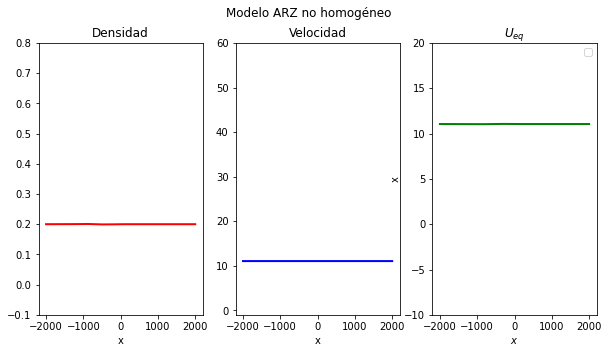

In [329]:
x_test, Q_test = godunov_ARZ(Q_0_test, dx, xl, xr, T, U, tau)
get_animation(Q_test, x_test, U, len(Q_test), "Modelo ARZ no homogéneo" ,
              ["Densidad", "Velocidad", r"$U_{eq}$"], "Charts/prueba.gif")

In [ ]:
density_integral(x_test, dx, len(Q_test), Q_test)

No hay solución
u_r =  9.373231844984799 demás =  9.308400557775297
No hay solución
u_r =  9.373231844984799 demás =  9.308400557775297


No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


KeyboardInterrupt: 

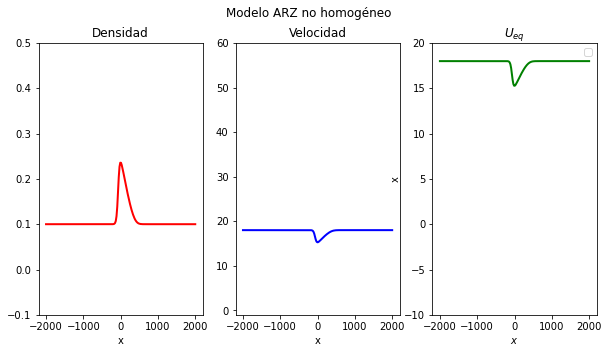

In [213]:
x_3, Q_3 = godunov_ARZ(Q_0_3, dx, xl, xr, T, U, tau)
get_animation(Q_3, x_3, U, len(Q_3), "Modelo ARZ no homogéneo" ,
              ["Densidad", "Velocidad", r"$U_{eq}$"], "Charts/Q_3_prueba.gif")

In [16]:
# Resuelve para cada condicion inicial
Q_0_s = [Q_0_2, Q_0_4]
x_s = []
Q_s = []

for i in range(len(Q_0_s)):
    x, Q = godunov_ARZ(Q_0_s[i], dx, xl, xr, T, U, tau)
    
    x_s += [x]
    Q_s += [Q]

No hay solución
u_r =  19.0 demás =  11.95445115010332
No hay solución
u_r =  19.0 demás =  11.95445115010332
No hay solución
u_r =  15.872714636977506 demás =  13.277015233271474
No hay solución
u_r =  15.872714636977506 demás =  13.277015233271474


No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.
No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


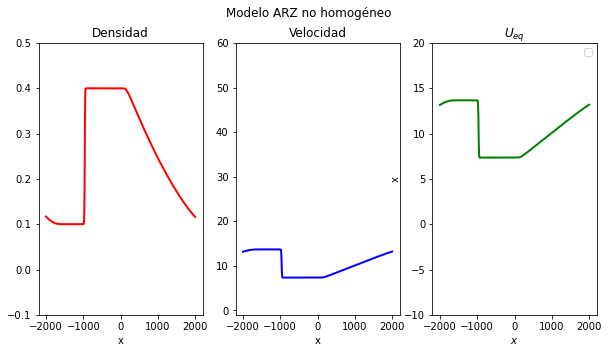

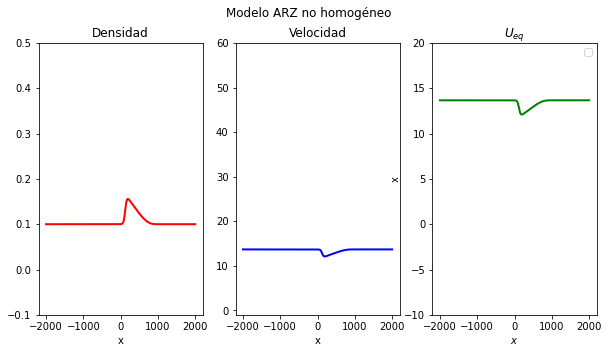

In [17]:
path = "Charts/"
names = ["2", "4"]

for i in range(len(Q_s)):
    name = "ARZ_no_homogeneo_Q_0_"+ names[i] +".gif"
    N_t = len(Q_s[i])
    get_animation(Q_s[i], x_s[i], U, N_t, "Modelo ARZ no homogéneo" ,["Densidad", "Velocidad", r"$U_{eq}$"], path+name)
    density_integral(x_s[i], dx, N_t, Q_s[i])

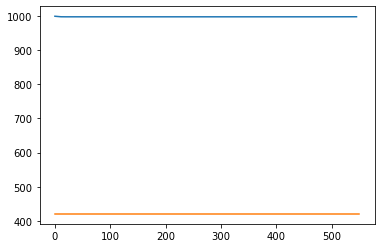

In [18]:
for i in range(len(Q_s)):
    density_integral(x_s[i], dx, len(Q_s[i]), Q_s[i])

## Ruta infinita

In [462]:
# Implementa Godunov con ruta infinita
# Borde izquierdo: Dirichlet
# Borde derecho: Neumann

def godunov_ARZ_inf(Q_0, dx, xl, xr, T, U, tau):
    
    # Largo de la grilla
    L = xr-xl
    
    # Numero de puntos
    N = int(L//dx)
    
    # Grilla
    x = np.linspace(xl, xr, N)
    
    # Guarda soluciones
    # Condición inicial
    Q = Q_0(x, U)
    dt = 0
    t = 0
    n = 0
    
    while t < T:
        
        # Actualiza segun condicion CFL
        dt = cfl(dt, dx, Q[n])
        l = dt/dx
        
        # Condición borde izq dirichlet
        
        if 0<t and t<50:
            # Densidad
            Q[n][0][0] = 0.2
        
            # Velocidad
            Q[n][1][0] = 0
        else:
            # Neumann
            # Densidad
            Q[n][0][0] = 0.55#Q[n][0][1]
        
            # Velocidad
            Q[n][1][0] = 1#Q[n][1][1]
            
        # Paso de Godunov
        Q_sig = Q[n] - l * F(Q[n], N, U, l)
        
        # Agrega no homogeneidad
        rho_sig, y_sig = Q_sig
        
        # Si aparece rho negativo
        neg_rho = rho_sig[rho_sig<0]
        if len(neg_rho)>0:
            print("rho negativo", neg_rho, " n = ", n)
            rho_sig[rho_sig<0] = 1e-1
        
        # Resuelve termino de relajación
        y_sig__ = y_sig * (1 - dt/(2 *tau * rho_sig))
        y_sig_ = y_sig - (dt * y_sig__)/(tau * rho_sig)
        Q_sig[1] = y_sig_
        
        # Condiciones borde der neumann
        Q_sig[:, -1] = Q_sig[:, -2]
        
        # Guarda paso
        Q_sig = np.reshape(Q_sig, (1, Q_sig.shape[0], Q_sig.shape[1]))
        Q = np.append(Q, Q_sig, axis=0)
        
        # Actualiza indice y tiempo
        n += 1
        t += dt
        
    return x, Q

In [463]:
# Condición inicial de prueba
# Constante por pedazos
def Q_0_test_inf(x, U):
    
    # Densidad alta en x negativo y bajo en x positivo
    rho_0 = np.piecewise(x, [((-25 <= x) & (x <= 0)), ((x>0) | (x<-25))], [0.6, 0.6])

    # Velocidad baja en negativos y alta en positivos
    u_0 = np.piecewise(x, [((-25 <= x) & (x <= 0)), ((x>0) | (x<-25))], [25, 25])

    # y inicial en funcion de u y rho
    y_0 = rho_0 * (u_0 - U(rho_0))

    # Vector con condición
    Q_0_ = np.zeros([1, 2, len(y_0)])
    Q_0_[0][0] = rho_0
    Q_0_[0][1] = y_0
    
    return Q_0_

In [464]:
# Parámetros
xl = -2000
xr = -xl
dx = 20
T = 500
tau= 5

No hay solución
u_r =  25.0 demás =  21.81818181818182
No hay solución
u_r =  21.23695109341525 demás =  20.0


No handles with labels found to put in legend.
MovieWriter ffmpeg unavailable; using Pillow instead.


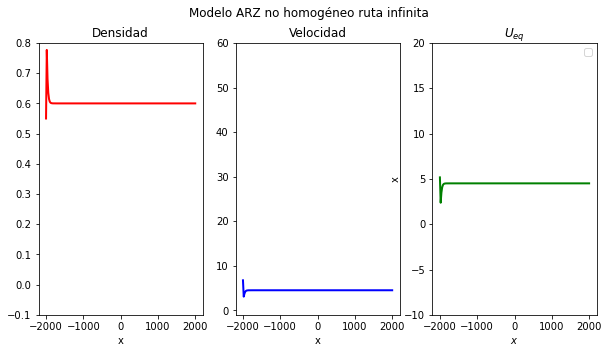

In [465]:
x_test_inf, Q_test_inf = godunov_ARZ_inf(Q_0_test_inf, dx, xl, xr, T, U, tau)
get_animation(Q_test_inf, x_test_inf, U, len(Q_test_inf), "Modelo ARZ no homogéneo ruta infinita" ,
              ["Densidad", "Velocidad", r"$U_{eq}$"], "Charts/prueba_inf.gif")

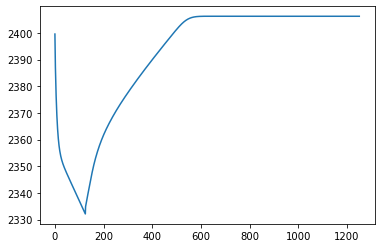

In [466]:
density_integral(x_test_inf, dx, len(Q_test_inf), Q_test_inf)

## Mayor resolución

In [19]:
def minmod(e, dx):
    
    sigma = numpy.zeros_like(e)
    de_minus = numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    
    de_minus[1:] = (e[1:] - e[:-1])/dx
    de_plus[:-1] = (e[1:] - e[:-1])/dx
    
    # The following is inefficient but easy to read
    for i in range(1, len(e)-1):
        if (de_minus[i] * de_plus[i] < 0.0):
            sigma[i] = 0.0
        elif (numpy.abs(de_minus[i]) < numpy.abs(de_plus[i])):
            sigma[i] = de_minus[i]
        else:
            sigma[i] = de_plus[i]
            
    return sigma

In [20]:
def F_minmod(Q, N, h, l, dx):
    
    F_ = np.zeros(Q.shape)
    for i in range(1, N-1):
        
        Q_left = Q[:, i-1]
        Q_i = Q[:, i]
        Q_right = Q[:, i+1]
        
        # Slopes
        delta_minus_e = (Q_i - Q_left)/dx
        delta_plus_e = (Q_right - Q_i)/dx
        
        # Slope con minmod
        sigma_i = minmod(delta_minus_e, delta_plus_e)
        
        Q_l = Q_i - sigma_i * dx / 2
        Q_r = Q_i + sigma_i * dx / 2
        
        w_left = w(Q_l, Q_i)
        w_right = w(Q_i, Q_r)
        
        F_[:, i] = flux(w_right, h) - flux(w_left, h)
    
    return F_

* TODO: Añadir pequeña difusión para arreglar las discontinuidades
    - Elementos finitos
    - Galerkin discontinuo